By: Noah Crowley

Case ID: nwc17

## The Problem

I am designing an algorithm that will track the number of active users on a website at any given time. The number of users on this website at a given time is calculated by the following: $$\lfloor A*f(t)\rfloor + n$$ Where t is the time of day (in minutes), A is the maximum number of users at any one point during the day without noise (chosen from a uniform distribution over a specified range), f is a function that maps the natural numbers to a value in the range [0, 1] in the real numbers, and $n \sim B(floor(\frac{A}{C}), 0.5)$ (where B is the binomial distribution and C is some integer constant).

The goal of the program is to approximate the value of A after watching the user traffic for one simulated week, with every minute of every day being simulated. Notice that, because I am using the absolute value of the sine function, this formula will create two peaks of traffic every day.

Beyond the scope of this particular assignment, the purpose of this system is to create the first building block of a Bayesian anomaly detection algorithm.

## Generating the data

This function generates a single datapoint. This function needs just a few things - A, t, f, and n. A, t, and f will be given, but n will be randomly selected within the function. In order to do this, I will need a binomial random distribution value function, which thankfully numpy already has for me. I also need some constants, such as the noise probability and other things. Additionally, I will add a boolean parameter in generate_data_point that toggles the noise so that I can show the actual data as a contrast.

In [56]:
import math
from numpy.random import binomial as binomial

minutes_in_day = 1440
noise_probability = 0.5
bounds_on_a = {"min": 0, "max": 100}
n_max_divisor = 2

def generate_data_point(A, f, t, include_noise = True):
    noise = 0
    if include_noise:
        noise = binomial(math.floor(A / n_max_divisor), noise_probability)
    f_result = f(t)
    total = math.floor(A * f_result) + noise
    return total

Although my algorithm is function-agnostic for f, I will create a simple function for f that uses the sine function:

In [7]:
def sine_based_population_generator(t):
    period = 2*math.pi/minutes_in_day
    return abs(math.sin(t * period))

I can create an entire week's dataset with a short for loop. I can also put this for loop into a function so that I can provide the number of days I want a data set for and I can provide the A value.

In [8]:
def create_data_set(num_days, A, f, include_noise = True):
    data_set = []
    for t in range(minutes_in_day * num_days):
        data_point = generate_data_point(A, f, t, include_noise)
        data_set.append(data_point)
    return data_set

This makes it easy to show an example data set generated from one day:

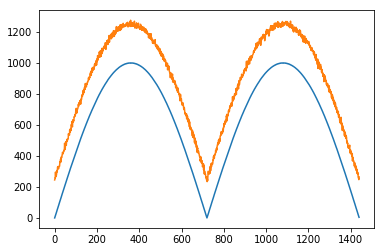

In [55]:
from matplotlib import pyplot as pyplot

no_noise_data_set = create_data_set(1, 1000, sine_based_population_generator, False)
example_data_set = create_data_set(1, 1000, sine_based_population_generator)

pyplot.plot(no_noise_data_set)
pyplot.plot(example_data_set)
pyplot.show()

## Using Bayes' Theorem

In order to utilize Bayesian inference, I need to define my prior, posterior, and likelihood. If $a$ is a given value of A, $\alpha$ is my normalizing constant, $d_{1:t}$ is the data vector from time 1 to time t, and $d_t$ is the data point at time t, then:

- Posterior: $p(A = a \mid d_{1:t}) = \alpha * p(d_{1:t} \mid A = a)p(A = a)$
- Likelihood: My likelihood here is somewhat complex. It is the product of all the data points likelihoods given each prior data point.
- Prior: My prior is very simple. It is just simply a constant that represents the probability of a being selected from the uniform discrete distribution of integers from 0 to 10,000.

This current system is looking fairly difficult to compute, at least for the likelihood. However, if I utilze the fact that each step is really just re-computing all prior steps, I can simplify my likelihood at the expense of my prior losing its state as a constant.

My new posterior, likelihood, and prior:

-    Posterior:
$$p(A = a \mid d_{1:t}) = \alpha * p(d_t \mid A = a)p(A = a \mid d_{1:t-1})$$
-   Likelihood: My likelihood here is very simple. It is simply the probability of a data point at time t having a specific value given A = a. I do not need to worry about the entire data set in the likelihood, which vastly simplifies the math.
    
   Now, it is easy to write my likelihood in algebraic terms. Since I am given the data point's value, a value of A to test for, a function, and the time, I am left with only one unknown: the noise. So, using algebra to solve for n, I get:
    
$$n = d_t - \lfloor A*f(t)\rfloor$$

<div style="margin-left: 30px;">Meaning my likelihood is really simply p(n | A = a), which is a simple calculation using the binomial distribution. However, I also need to check that n is within the range [0, A/C], otherwise the likelihood is 0. So, my likelihood can be expressed as:</div>

$$
\begin{cases}
\binom{\frac{A}{C}}{n} (0.5)^n (0.5)^{\frac{A}{C} - n}, & \text{if 0 <= n <= A/C} \\
0, & \text{otherwise}
\end{cases}
$$
    
-   Prior: My prior is very simple, though now less simple than before. It is just the posterior from time step t-1. At t = 1, it will simply be the uniform probability of A given no samples.

I can then compute $\alpha$ by summing my posteriors over all the possible values of A, then dividing each posterior by that sum.

For my likelihood function, I will need the given value of a, the function f, the time t, and the individual data point at time t. In code, this looks like this:

In [61]:
from scipy.misc import comb as choose

def calculate_likelihood(a, f, t, data_point):
    f_result = f(t)
    n = data_point - math.floor(a * f_result)
    
    if n < bounds_on_a["min"] or n > bounds_on_a["max"]:
        return 0
    
    choose_result = choose(math.floor(a/n_max_divisor), n)
    probabilities = (noise_probability)**n * (noise_probability)**(math.floor(a/n_max_divisor) - n)
    binomial_probability = choose_result * probabilities
    return binomial_probability

And then, for my posterior probability, the function is quite simple. I only need the given value of a, the function f, the time t, the data point at time t, and the existing prior, much like I did for the likelihood. At first, I will not normalize my posterior, as that will come later. In code, this looks like this:

In [11]:
def calculate_unnormalized_posterior(a, f, t, data_point, prior):
    return calculate_likelihood(a, f, t, data_point) * prior

## Putting it all together

I now have all of the base methods necessary to carry out my approximation. I simply need to create a method that generates a data vector, iterates over each data point, and estimates the value of A after iterating over the entire data set. In order to make this flexible so that I can generate multiple graphs, I will create a method that takes just f and a pre-generated data set and returns the estimated probability distribution of A:

In [37]:
def estimate_distribution_of_a(f, data):
    length_of_bounds = bounds_on_a["max"] - bounds_on_a["min"]
    a_distribution = [1.0 / length_of_bounds] * length_of_bounds
    
    for t in range(len(data)):
        total_sum = 0
        for i in range(length_of_bounds):
            a = bounds_on_a["min"] + i
            new_posterior = calculate_unnormalized_posterior(a, f, t, data[t], a_distribution[i])
            total_sum += new_posterior
            a_distribution[i] = new_posterior
            
        if total_sum > 0:
            for i in range(length_of_bounds):
                a_distribution[i] /= total_sum
                
    return a_distribution

So now, I can simply call the above method with a data set and estimate the value of A, and then show that estimation at multiple points throughout the process.

In [81]:
import random

def run(f):
    a = random.randint(bounds_on_a["min"], bounds_on_a["max"] + 1)
    print("A has been selected to be {:d}.".format(a))
    
    total_days = 7
    data = create_data_set(total_days, a, f)
    print("Data has been created for {:d} days.".format(total_days))
    
    print("Results after five minutes:")
    five_minutes_results = estimate_distribution_of_a(f, data[0:5])
    pyplot.plot(five_minutes_results)
    pyplot.show()
    
    print("Results after the first half hour:")
    first_half_hour_distribution = estimate_distribution_of_a(f, data[0:30])
    pyplot.plot(first_half_hour_distribution)
    pyplot.show()
    
    print("Results after the first day:")
    first_half_day_distribution = estimate_distribution_of_a(f, data[0:minutes_in_day])
    pyplot.plot(first_half_day_distribution)
    pyplot.show()
    
    print("Results after the entire week:")
    final_distribution = estimate_distribution_of_a(f, data)
    pyplot.plot(final_distribution)
    pyplot.show()
    
    most_likely_value = 0
    probability_of_value = 0
    for i in range(len(final_distribution)):
        a_value = bounds_on_a["min"] + i
        probability = final_distribution[i]
        
        if probability > probability_of_value:
            probability_of_value = probability
            most_likely_value = a_value
            
    print("And the predicted value is {:d} with probability {:f}.".format(most_likely_value, probability_of_value))
    if (most_likely_value == a):
        print("The prediction is correct!")
    else:
        print("The prediction was incorrect. The correct value was {:d}.".format(a))

A has been selected to be 70.
Data has been created for 7 days.
Results after five minutes:


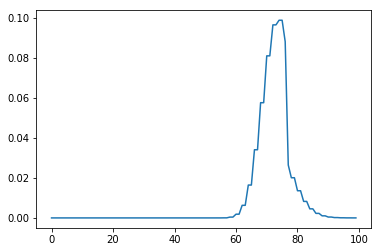

Results after the first half hour:


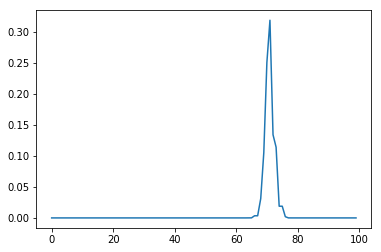

Results after the first day:


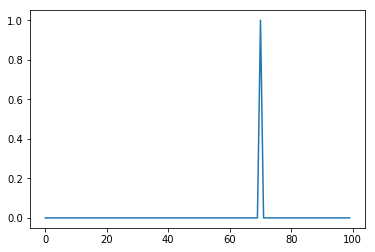

Results after the entire week:


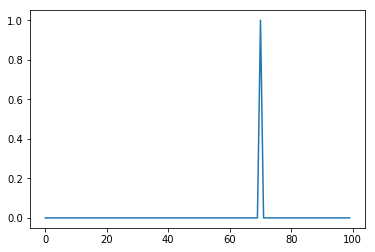

And the predicted value is 70 with probability 1.000000.
The prediction is correct!


In [82]:
run(sine_based_population_generator)

Of course, it is important to also illustrate that this works agnostically to the function f, so long as f fits the critera of going from the natural numbers to the real range [0, 1]. This is done here:

A has been selected to be 47.
Data has been created for 7 days.
Results after five minutes:


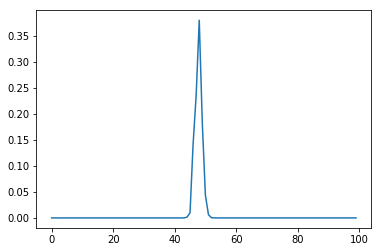

Results after the first half hour:


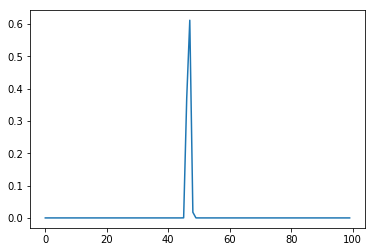

Results after the first day:


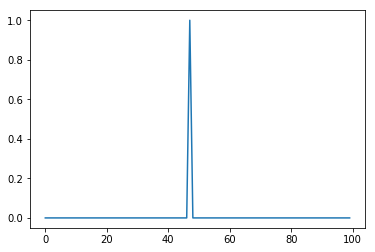

Results after the entire week:


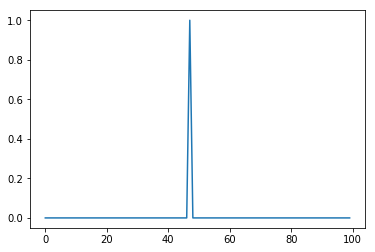

And the predicted value is 47 with probability 1.000000.
The prediction is correct!


In [85]:
def even_equals_one(t):
    if t % 2 == 0:
        return 1
    else:
        return 0
    
run(even_equals_one)

## Thinking beyond this work

The beauty of this is that it will also function given a less simple function. For instance, on a real website there may be a long history of traffic data. This data could be gathered and put into a minute-to-minute list (or any other time interval, really) of averages for that time of day, and then used to return the average of that minute divided by the average peak value. Then, using that normalized set of averages, this function could find what the amplitude is for a given day, and then a growth of A could be recorded and plotted to show growth in a website's popularity.

I have also thought of giving each minute a normal distribution which would allow for the estimation of the probability of a given value at a given time. This could be helpful for quickly detecting problems in a server or other item. This is also agnostic to the idea of a fluctuating system, such as users on a website, as it could also apply to a more constant function such as number of servers online at a given time. Though this idea would require quite a few modifications.